![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 6.2. Poisson Regression Model with Offset (Rate Data)

In many real-world scenarios, we’re interested not just in the count of occurrences of an event but also in the rate at which the event occurs over a specific exposure period (e.g., the number of road accidents per mile or cases of a disease per population over a set timeframe). This type of data is often called "rate data" and is particularly well-suited to Poisson regression with an offset. An offset variable allows us to account for the varying exposure times or population sizes in our data, making it possible to model the rate of events rather than simply the count.

This tutorial will dive into Poisson regression with an offset, which is essential when analyzing rate data. We’ll start with a model overview, discussing the purpose and assumptions of Poisson regression with an offset term. We’ll then move on to fitting the model both from scratch (to gain insights into how it works) and with R’s convenient glm() function. Following this, we’ll examine model diagnosis techniques to ensure the model fits the data well, discuss model evaluation methods, and conclude with the interpretation of incidence rate ratios (IRRs), which help quantify the predictors' effect on the rate outcome.

## Overview

**Poisson regression** is commonly used to model **rates** instead of simple **counts** in practical applications. For example, if you want to model the rate of events happening over time, space, or another unit of exposure (such as the number of accidents per mile driven or the number of diseases per population), you need to consider the varying levels of exposure across different observations. This is where the concept of an **offset** comes into play. An **offset** is a known quantity (the exposure) that adjusts the model to accurately represent the rate of event occurrence.

***What is an Offset?***

- The **offset** in Poisson regression represents the **logarithm** of the exposure variable. The exposure variable is the denominator in the rate calculation (e.g., time, population, or space).
- The offset allows us to model the number of events **per unit of exposure**, rather than just raw counts.



The standard Poisson regression model for counts is:

$$ \log(\lambda_i) = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_p X_{pi} $$

Where:

- $\lambda_i$ is the expected count for the $i^{th}$ observation.
- $X_{1i}, X_{2i}, \dots, X_{pi}$ are the predictor variables.
- $beta_0, \beta_1, \dots, \beta_p$ are the regression coefficients.

In the **Poisson regression with offset**, we modify the model to incorporate the exposure variable $e_i$. The offset term is the **log** of the exposure, ensuring that the response variable is modeled as a **rate** rather than a simple count.

The model becomes:

$$ log(\lambda_i) = \beta_0 + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_p X_{pi} + \log(e_i) $$

Or equivalently:

$$ lambda_i = e_i \exp(\beta_0 + \beta_1 X_{1i} + \dots + \beta_p X_{pi}) $$

Where:

- $e_i$ is the exposure (e.g., time, population size, or area).
- $\lambda_i$ is now the expected **rate of events** per unit of exposure.
- $\log(e_i)$ is added as a known term (the offset) and is not estimated as part of the model.

**Why Use an Offset?**

The offset is critical when:
1. **Exposure varies across observations**: In many datasets, each observation may have a different level of exposure (e.g., different time periods, population sizes, or geographic areas). The offset adjusts for these differences.
2. **Modeling rates**: Poisson regression with an offset models rates (e.g., the number of events per unit of exposure) rather than raw counts.

Without the offset, the model would incorrectly treat counts as if all observations had the same exposure.



## Poisson Model with an  offset

Let's go through the process of fitting a Poisson model with an offset and four predictors manually in R. Here’s the breakdown:

*  **Create a  Data**: Load or simulate count data with four predictors and an offset.
* **Specify the Poisson Model with Offset**: Write the log-likelihood function to include the offset.
*  **Optimize the Parameters**: Use the `optim()` function to maximize the log-likelihood.
* **Create a Summary Statistics Table**: Calculate standard errors and create a summary table.

## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314969 sha256=9bdbd9e375b1f9806d6d4cb1b20e579727e25b94cc786b525adbd8717fef7277
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Poisson Model from Scratch

Let's go through the process of fitting a Poisson model with an offset and four predictors manually in R. Here’s the breakdown:

*  **Create a  Data**: Load or simulate count data with four predictors and an offset.
* **Specify the Poisson Model with Offset**: Write the log-likelihood function to include the offset.
*  **Optimize the Parameters**: Use the `optim()` function to maximize the log-likelihood.
* **Create a Summary Statistics Table**: Calculate standard errors and create a summary table.

### Create a Data

For this example, we’ll simulate some count data, including four predictors and an offset variable.


In [ ]:
%%R
set.seed(123)
n <- 100  # sample size

# Generate predictors
x1 <- rnorm(n)
x2 <- rnorm(n)
x3 <- rnorm(n)
x4 <- rnorm(n)
offset <- log(1 + rnorm(n, mean = 5, sd = 1))  # Offset term

# Generate response variable y using a true model with coefficients
beta <- c(0.5, 0.3, -0.2, 0.4, 0.1)
lambda <- exp(beta[1] + beta[2] * x1 + beta[3] * x2 + beta[4] * x3 + beta[5] * x4 + offset)
y <- rpois(n, lambda)

# Combine into a data frame
data <- data.frame(y, x1, x2, x3, x4, offset)
head(data)


   y          x1          x2         x3         x4   offset
1 18 -0.56047565 -0.71040656  2.1988103 -0.7152422 1.779424
2 14 -0.23017749  0.25688371  1.3124130 -0.7526890 1.575126
3 11  1.55870831 -0.24669188 -0.2651451 -0.9385387 1.679943
4 10  0.07050839 -0.34754260  0.5431941 -1.0525133 1.786941
5 10  0.12928774 -0.95161857 -0.4143399 -0.4371595 1.897724
6  9  1.71506499 -0.04502772 -0.4762469  0.3311792 1.470050


### Specify the Poisson Model with Offset

The Poisson regression model with an offset can be specified as follows:

$$ \log(\lambda) = \beta_0 + \beta_1 \cdot x1 + \beta_2 \cdot x2 + \beta_3 \cdot x3 + \beta_4 \cdot x4 + \text{offset} $$

Here’s the log-likelihood function for this model:

In [ ]:
%%R
# Log-likelihood function for Poisson regression with offset
poisson_log_likelihood_offset <- function(params) {
  beta0 <- params[1]
  beta1 <- params[2]
  beta2 <- params[3]
  beta3 <- params[4]
  beta4 <- params[5]

  # Compute lambda (expected counts)
  lambda <- exp(beta0 + beta1 * data$x1 + beta2 * data$x2 + beta3 * data$x3 + beta4 * data$x4 + data$offset)

  # Log-likelihood for Poisson with offset
  log_likelihood <- sum(dpois(data$y, lambda, log = TRUE))

  return(-log_likelihood)  # Negative for minimization
}

### Optimize the Parameters

Now we’ll use `optim()` to estimate the parameters by maximizing the log-likelihood function.

In [ ]:
%%R
# Initial guesses for beta coefficients
initial_params <- rep(0, 5)

# Use optim to find MLEs for the coefficients
fit <- optim(par = initial_params, fn = poisson_log_likelihood_offset, hessian = TRUE)

# Extract parameter estimates and standard errors
coefficients <- fit$par
std_errors <- sqrt(diag(solve(fit$hessian)))

# Display estimated coefficients
cat("Estimated coefficients:\n", coefficients, "\n")
cat("Standard errors:\n", std_errors, "\n")

Estimated coefficients:
 0.4782902 0.3155381 -0.1964496 0.4065897 0.1329681 
Standard errors:
 0.03480884 0.03106314 0.03297209 0.03000168 0.02880428 


### Create a Summary Statistics Table

To summarize the results, let’s calculate the Z-scores and p-values for each coefficient.


In [ ]:
%%R
# Calculate Z-scores and p-values
z_scores <- coefficients / std_errors
p_values <- 2 * (1 - pnorm(abs(z_scores)))

# Create summary table
summary_table <- data.frame(
  Coefficient = coefficients,
  Std_Error = std_errors,
  Z_value = z_scores,
  P_value = p_values
)

# Assign row names for clarity
row.names(summary_table) <- c("Intercept", "x1", "x2", "x3", "x4")

# Display summary table
print(summary_table)

          Coefficient  Std_Error   Z_value      P_value
Intercept   0.4782902 0.03480884 13.740481 0.000000e+00
x1          0.3155381 0.03106314 10.157957 0.000000e+00
x2         -0.1964496 0.03297209 -5.958056 2.552555e-09
x3          0.4065897 0.03000168 13.552230 0.000000e+00
x4          0.1329681 0.02880428  4.616262 3.907138e-06


###  Check for Overdispersion

To check for overdispersion, calculate the dispersion statistic, which is the ratio of the residual deviance to the degrees of freedom.


In [ ]:
%%R
# estimaates
estimates <- fit$par
names(estimates ) <- c("beta0", "beta1", "beta2", "beta3", "beta4")
# Calculate fitted values
lambda_hat <- exp(estimates[1] + estimates[2] * data$x1 + estimates[3] * data$x2 +
                  estimates[4] * data$x3 + estimates[5] * data$x4 + data$offset)


# Calculate Pearson residuals
pearson_residuals <- (data$y - lambda_hat) / sqrt(lambda_hat)

# Calculate dispersion statistic
dispersion_statistic <- sum(pearson_residuals^2) / (n - length(estimates))

# Display dispersion statistic
cat("Dispersion Statistic:", dispersion_statistic, "\n")

# If the dispersion statistic is much greater than 1, overdispersion is present
if (dispersion_statistic > 1.2) {
  cat("Warning: Evidence of overdispersion\n")
} else {
  cat("No evidence of overdispersion\n")
}

Dispersion Statistic: 0.9083263 
No evidence of overdispersion


## Poisson Model with R


In this exercise we will develop a Poisson regression model with `offset` in  R with a built in function `glm() `to explain the variability the diagnosed diabetes rate per county in the USA.


### Install Required R Packages



In [5]:
%%R
packages <- c('tidyverse',
     'plyr',
	   'DataExplorer',
		 'dlookr',
		 'rstatix',
		 'gtsummary',
		 'performance',
		 'jtools',
		 'margins',
		 'marginaleffects',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'ggpmisc',
		 'epiDisplay',
		 'sandwich'
		  )


In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [6]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method          from  
  plot.transform  scales
  print.transform scales

  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2



      tidyverse            plyr    DataExplorer          dlookr         rstatix 
           TRUE            TRUE            TRUE            TRUE            TRUE 
      gtsummary     performance          jtools         margins marginaleffects 
           TRUE            TRUE            TRUE            TRUE            TRUE 
      ggeffects       patchwork         Metrics         ggpmisc      epiDisplay 
           TRUE            TRUE            TRUE            TRUE            TRUE 
       sandwich 
           TRUE 


### Load R Packages


In [7]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages

Successfully loaded packages:
 [1] "package:sandwich"        "package:epiDisplay"     
 [3] "package:nnet"            "package:MASS"           
 [5] "package:survival"        "package:foreign"        
 [7] "package:ggpmisc"         "package:ggpp"           
 [9] "package:Metrics"         "package:patchwork"      
[11] "package:ggeffects"       "package:marginaleffects"
[13] "package:margins"         "package:jtools"         
[15] "package:performance"     "package:gtsummary"      
[17] "package:rstatix"         "package:dlookr"         
[19] "package:DataExplorer"    "package:plyr"           
[21] "package:lubridate"       "package:forcats"        
[23] "package:stringr"         "package:dplyr"          
[25] "package:purrr"           "package:readr"          
[27] "package:tidyr"           "package:tibble"         
[29] "package:ggplot2"         "package:tidyverse"      
[31] "package:tools"           "package:stats"          
[33] "package:graphics"        "package:grDevices"      
[

### Data

The County-level age-adjusted number and rate of diabetes patients, prevalence of obesity, physical inactivity and [Food environment index](https://www.ers.usda.gov/data-products/food-environment-atlas.aspx) for the year 2016-2020 were obtained from United States [Diabetes Surveillance System (USDSS)](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html).

![alt text](http://drive.google.com/uc?export=view&id=1pNL0FF71fPQqfSffEMjHuIdGdiZdYVDs)

Full data set is available for download from my [Dropbox](https://www.dropbox.com/scl/fi/ynrinqzj58f3x5mvc96as/county_data_2016_2020.csv?rlkey=zpy7qxrh6r4l01ct4hjxgcnds&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.



Dataset contains five years average (2016-2020) of following variables :

1.  `Diabetes_count` -  Diabetes number per county ([Diabetes Surveillance System (USDSS))](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html)

2.  `Diabetes_per` - Diabetes number per county [(Diabetes Surveillance System (USDSS))](https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html)

3. `Urban_Rural` - Urban Rural County (USDA)

4. `PPO_total` - Total population per  county (US Census)

5. `Obesity` - % obesity per county [(Behavioral Risk Factor Surveillance System)](https://www.cdc.gov/brfss/)  

6. `Physical_Inactivity`: % adult access to exercise opportunities ([County Health Ranking](https://www.countyhealthrankings.org/health-data/methodology-and-sources/data-documentation))

7. `SVI` - Level of social vulnerability in the county relative to other counties in the nation or within the state.ocial vulnerability refers to the potential negative effects on communities caused by external stresses on human health. The CDC/ATSDR Social vulnerability Index (SVI) ranks all US counties on 15 social factors, including poverty, lack of vehicle access, and crowded housing, and groups them into four related themes. ( [CDC/ATSDR Social Vulnerability Index (SVI)](https://www.atsdr.cdc.gov/placeandhealth/svi/interactive_map.html))

8. `Food_Env_Index`: Measure of access to healthy food. The Food Environment Index ranges from a scale of 0 (worst) to 10 (best) and equally weights two indicators: 1) Limited access to healthy foods based on distance an individual lives from a grocery store or supermarket, locations for healthy food purchases in most communities; and 2) Food insecurity defined as the inability to access healthy food because of cost barriers.[County Health Ranking](https://www.countyhealthrankings.org/health-data/methodology-and-sources/data-documentation)

We will use `read_csv()` function of {readr} package to import data as a `tidy` data.


In [ ]:
%%R
# load data
mf<-read_csv("https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/county_data_2016_2020.csv")
# select variables
df<-mf |>
  dplyr::select(Diabetes_per,
                POP_Total,
                Obesity,
                Physical_Inactivity,
                Access_Excercise,
                Food_Env_Index,
                SVI,
                Urban_Rural
                ) |>
  glimpse()
# data processing
df$Diabetes_per<-as.integer(df$Diabetes_per)
df$Urban_Rural<-as.factor(df$Urban_Rural)

Rows: 3107 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): State, County, Urban_Rural
dbl (12): FIPS, X, Y, POP_Total, Diabetes_count, Diabetes_per, Obesity, Acce...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3,107
Columns: 8
$ Diabetes_per        <dbl> 9.24, 8.48, 11.72, 10.08, 10.26, 9.06, 11.80, 13.2…
$ POP_Total           <dbl> 55707.0, 218346.8, 25078.2, 22448.2, 57852.4, 1017…
$ Obesity             <dbl> 29.22, 28.94, 29.34, 29.44, 30.10, 19.86, 30.38, 3…
$ Physical_Inactivity <dbl> 26.42, 22.86, 23.72, 25.38, 24.76, 18.58, 28.66, 2…
$ Access_Excercise    <dbl> 70.8, 72.2, 49.8, 30.6, 24.6, 19.6, 48.0, 51.4, 62…
$ Food_Env_Index      <dbl> 6.9, 7.7, 5.5, 7.6, 8.1, 4.3, 6.5, 6.3, 6.4, 7.7, …
$ SVI                 <dbl> 0.5130, 0.3103, 0.9927, 0.8078, 0.5137, 0.8310, 0.…
$ Urban_Rural         <chr

### Data Description

The {epidisplay} package can provide both numerical and categorical statistics simultaneously with the `codebook()` function. It's a great tool for descriptive statistics.

In [ ]:
%%R
epiDisplay::codebook(df[,1:7])


 
 
Diabetes_per 	 : 	  

No. of observations = 3107

  Var. name    obs. mean   median  s.d.   min.   max.  
1 Diabetes_per 3107 8.1    8       1.6    3      16    

Obesity 	 : 	  

No. of observations = 3107

  Var. name obs. mean   median  s.d.   min.   max.  
1 Obesity   3107 27.59  27.86   4.8    12.06  42.12 

Physical_Inactivity 	 : 	  

No. of observations = 3107

  Var. name           obs. mean   median  s.d.   min.   max.  
1 Physical_Inactivity 3107 21.16  20.84   4.3    9.64   36.72 

Access_Excercise 	 : 	  

No. of observations = 3107

  Var. name        obs. mean   median  s.d.   min.   max.  
1 Access_Excercise 3107 61.98  64      21.78  0      100   

Food_Env_Index 	 : 	  

No. of observations = 3107

  Var. name      obs. mean   median  s.d.   min.   max.  
1 Food_Env_Index 3107 7.32   7.5     1.09   1.6    10    

SVI 	 : 	  

No. of observations = 3107

  Var. name obs. mean   median  s.d.   min.   max.  
1 SVI       3107 0.5    0.5     0.29   0      1     

Urba

#### Density Plot

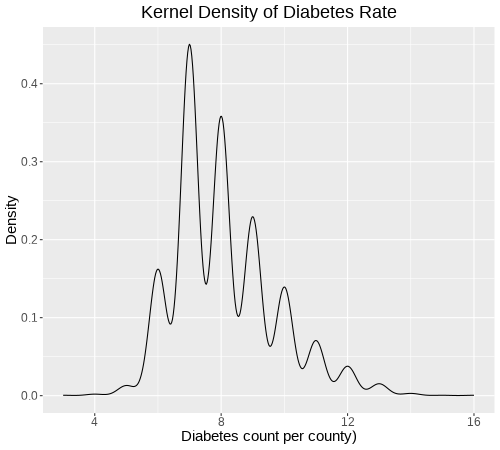

In [ ]:
%%R -h 450 -w 500 -u px
ggplot(df, aes(Diabetes_per)) +
  geom_density()+
  # x-axis title
  xlab("Diabetes count per county)") +
  # y-axis title
  ylab("Density")+
  # plot title
  ggtitle("Kernel Density of Diabetes Rate")+
    theme(
    # Center the plot title
    plot.title = element_text(hjust = 0.5))

#### Descriptive Statistics

In [ ]:
%%R
# Standard error
SE <- function(x){
  sd(x)/sqrt(length(x))
}

# Get summary statistics
summarise_diabetes<-plyr::ddply(df,~ Urban_Rural, summarise,
                Mean= round(mean(Diabetes_per), 2),
                Median=round (median(Diabetes_per ), 2),
                Min= round (min(Diabetes_per),2),
                Max= round (max(Diabetes_per),2),
                SD= round(sd(Diabetes_per), 2),
                SE= round (SE(Diabetes_per ), 3))
summarise_diabetes

  Urban_Rural Mean Median Min Max   SD    SE
1       Rural 7.75      7   4  16 1.53 0.042
2       Urban 8.35      8   3  15 1.61 0.038


#### Boxplot - Urban vs Rural

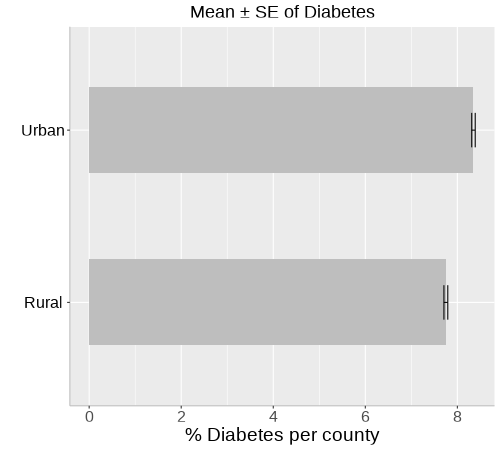

In [ ]:
%%R -h 450 -w 500 -u px
ggplot(summarise_diabetes, aes(x=Urban_Rural, y=Mean)) +
  geom_bar(stat="identity", position=position_dodge(),width=0.5, fill="gray") +
  geom_errorbar(aes(ymin=Mean-SE, ymax=Mean+SE), width=.2,
   position=position_dodge(.9))+
  # add y-axis title and x-axis title leave blank
  labs(y="% Diabetes per county", x = "")+
  # add plot title
  ggtitle("Mean ± SE of Diabetes Rate")+
  coord_flip()+
  # customize plot themes
  theme(
        axis.line = element_line(colour = "gray"),
        # plot title position at center
        plot.title = element_text(hjust = 0.5),
        # axis title font size
        axis.title.x = element_text(size = 14),
        # X and  axis font size
        axis.text.y=element_text(size=12,vjust = 0.5, hjust=0.5, colour='black'),
        axis.text.x = element_text(size=12))


#### Correlation Plot

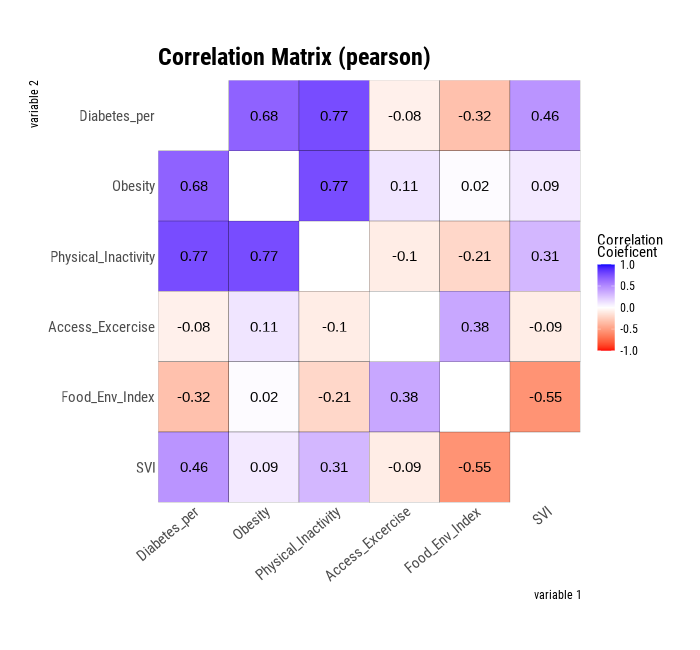

In [ ]:
%%R -h 650 -w 700 -u px
# Correlation plot
df |>
  # select variables
  dplyr::select (Diabetes_per,
                Obesity,
                Physical_Inactivity,
                Access_Excercise,
                Food_Env_Index,
                SVI
                ) |>
  dlookr::correlate() |>
  plot()

Let explore correlation in rural and urban counties:

Adding missing grouping variables: `Urban_Rural`


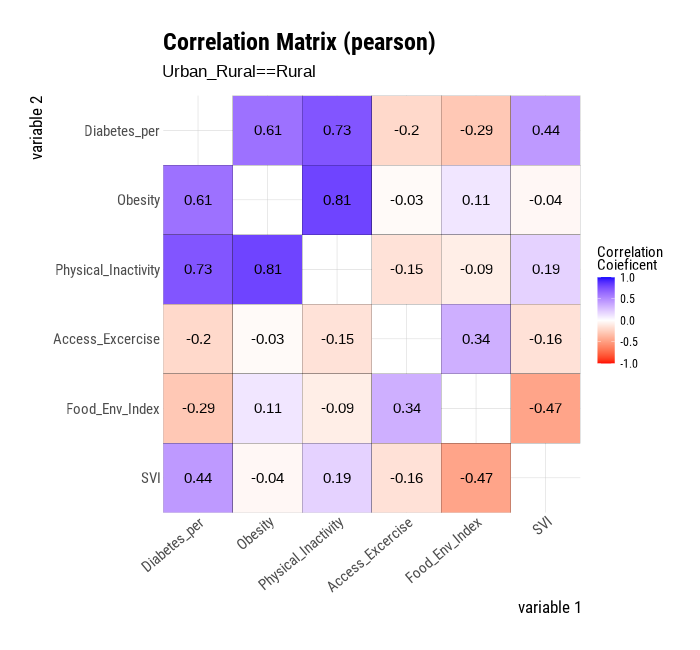

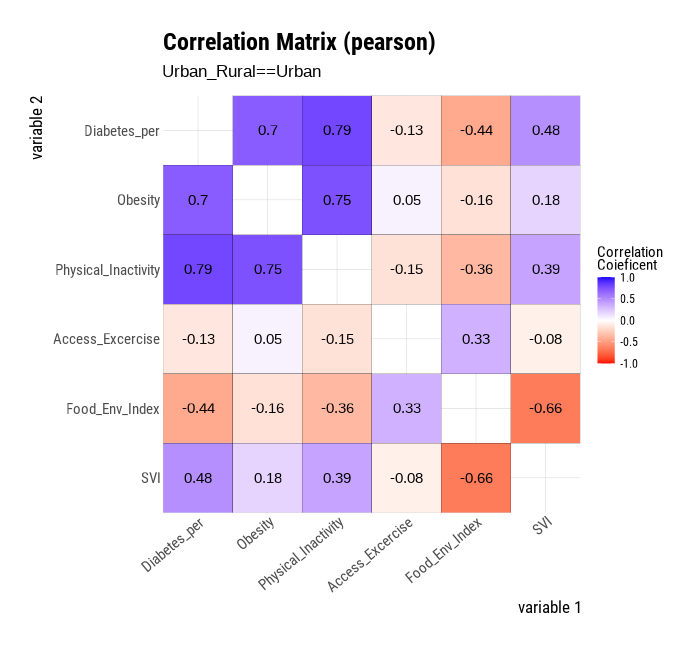

In [ ]:
%%R -h 650 -w 700 -u px
df |>
  group_by(Urban_Rural) |>
  # select variables
  dplyr::select (Diabetes_per,
                Obesity,
                Physical_Inactivity,
                Access_Excercise,
                Food_Env_Index,
                SVI
                ) |>
  dlookr::correlate() |>
  plot()

### Split Data

We will use the `ddply()` function of the {plyr}  package to split soil carbon datainto homogeneous subgroups using **stratified random sampling**. This method involves dividing the population into strata and taking random samples from each stratum to ensure that each subgroup is proportionally represented in the sample. The goal is to obtain a representative sample of the population by adequately representing each stratum.

In [ ]:
%%R
seeds = 11076
tr_prop = 0.70

df$log_POP_Total<-log(df$POP_Total)
# training data (70% data)
train= ddply(df,.(Urban_Rural),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = ddply(df, .(Urban_Rural),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)

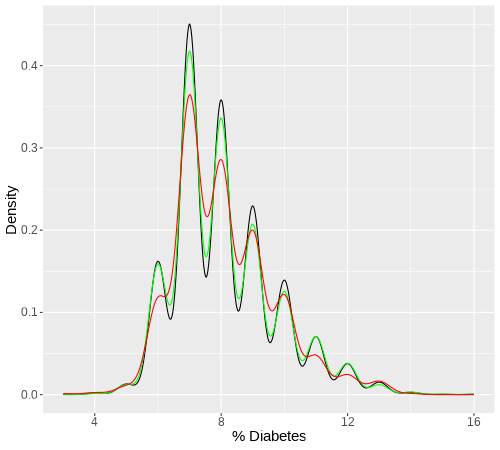

In [ ]:
%%R -h 450 -w 500 -u px
# Density plot all, train and test data
ggplot()+
  geom_density(data = df, aes(Diabetes_per))+
  geom_density(data = train, aes(Diabetes_per), color = "green")+
  geom_density(data = test, aes(Diabetes_per ), color = "red") +
      xlab("% Diabetes") +
     ylab("Density")

### Fit a Poisson Model with Offset

We will fit a Poisson regression model using the `glm()` function in R. We specify `family = poisson(link = "log")` to indicate that we want to fit a Poisson regression model. Here we model the diabetes rate per county, The `offset` variable, here is log population per county need to be defined in model. This offset variable adjusts for the differing number of diabetes patients in different population levels per county.

In [ ]:
%%R
fit.pois <- glm(
            Diabetes_per  ~
                Obesity +
                Physical_Inactivity +
                Access_Excercise +
                Food_Env_Index +
                SVI +
                Urban_Rural+
                offset(log_POP_Total),
                family = poisson(link = "log"),
                data = train)

### Model Summary

`summary()` function produce result summaries of the results of model fitting functions.

In [ ]:
%%R
summary(fit.pois)


Call:
glm(formula = Diabetes_per ~ Obesity + Physical_Inactivity + 
    Access_Excercise + Food_Env_Index + SVI + Urban_Rural + offset(log_POP_Total), 
    family = poisson(link = "log"), data = train)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.1137977  0.0882815 -23.944  < 2e-16 ***
Obesity             -0.0245887  0.0025489  -9.647  < 2e-16 ***
Physical_Inactivity  0.0231530  0.0028876   8.018 1.07e-15 ***
Access_Excercise    -0.0329137  0.0004251 -77.431  < 2e-16 ***
Food_Env_Index      -0.3835297  0.0093947 -40.824  < 2e-16 ***
SVI                 -1.6921128  0.0349250 -48.450  < 2e-16 ***
Urban_RuralUrban    -1.0635240  0.0199055 -53.429  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 42667  on 2172  degrees of freedom
Residual deviance: 13198  on 2166  degrees of freedom
AIC: 21756

Number of Fisher Scoring iteratio

`report()` function of {report} package generate a brief  report of fitted model

In [ ]:
%%R
report::report(fit.pois)

We fitted a poisson model (estimated using ML) to predict Diabetes_per with
Obesity, Physical_Inactivity, Access_Excercise, Food_Env_Index, SVI,
Urban_Rural and log_POP_Total (formula: Diabetes_per ~ Obesity +
Physical_Inactivity + Access_Excercise + Food_Env_Index + SVI + Urban_Rural +
offset(log_POP_Total)). The model's explanatory power is substantial
(Nagelkerke's R2 = 1.00). The model's intercept, corresponding to Obesity = 0,
Physical_Inactivity = 0, Access_Excercise = 0, Food_Env_Index = 0, SVI = 0,
Urban_Rural = Rural and log_POP_Total = 0, is at -2.11 (95% CI [-2.29, -1.94],
p < .001). Within this model:

  - The effect of Obesity is statistically significant and negative (beta =
-0.02, 95% CI [-0.03, -0.02], p < .001; Std. beta = -0.08, 95% CI [-0.10,
-0.05])
  - The effect of Physical Inactivity is statistically significant and positive
(beta = 0.02, 95% CI [0.02, 0.03], p < .001; Std. beta = 0.09, 95% CI [0.06,
0.11])
  - The effect of Access Excercise is statistically sign

The {jtools} package consists of a series of functions to create summary of the poisson regression model:

In [ ]:
%%R
jtools::summ(fit.pois)

MODEL INFO:
Observations: 2173
Dependent Variable: Diabetes_per
Type: Generalized linear model
  Family: poisson 
  Link function: log 

MODEL FIT:
χ²(6) = 29468.92, p = 0.00
Pseudo-R² (Cragg-Uhler) = 1.00
Pseudo-R² (McFadden) = 0.58
AIC = 21756.41, BIC = 21796.20 

Standard errors:MLE
--------------------------------------------------------
                             Est.   S.E.   z val.      p
------------------------- ------- ------ -------- ------
(Intercept)                 -2.11   0.09   -23.94   0.00
Obesity                     -0.02   0.00    -9.65   0.00
Physical_Inactivity          0.02   0.00     8.02   0.00
Access_Excercise            -0.03   0.00   -77.43   0.00
Food_Env_Index              -0.38   0.01   -40.82   0.00
SVI                         -1.69   0.03   -48.45   0.00
Urban_RuralUrban            -1.06   0.02   -53.43   0.00
--------------------------------------------------------


We can use  the R package {sandwich} to obtain the `robust standard errors` and subsequently calculated the `p-values`. Additionally, we computed the 95% confidence interval using the parameter estimates and their robust standard errors.

In [ ]:
%%R
cov.m1 <- vcovHC(fit.pois, type="HC0")
std.err <- sqrt(diag(cov.m1))
r.est <- cbind(Estimate= coef(fit.pois), "Robust SE" = std.err,
"Pr(>|z|)" = 2 * pnorm(abs(coef(fit.pois)/std.err), lower.tail=FALSE),
LL = coef(fit.pois) - 1.96 * std.err,
UL = coef(fit.pois) + 1.96 * std.err)

r.est

                       Estimate   Robust SE      Pr(>|z|)           LL
(Intercept)         -2.11379767 0.234805265  2.209498e-19 -2.574015991
Obesity             -0.02458873 0.008547439  4.018105e-03 -0.041341712
Physical_Inactivity  0.02315297 0.008852013  8.908130e-03  0.005803024
Access_Excercise    -0.03291368 0.001185037 8.845286e-170 -0.035236351
Food_Env_Index      -0.38352972 0.027997939  1.036458e-42 -0.438405677
SVI                 -1.69211275 0.120184605  5.092571e-45 -1.927674577
Urban_RuralUrban    -1.06352403 0.042747135 1.242722e-136 -1.147308415
                              UL
(Intercept)         -1.653579352
Obesity             -0.007835752
Physical_Inactivity  0.040502913
Access_Excercise    -0.030591006
Food_Env_Index      -0.328653756
SVI                 -1.456550926
Urban_RuralUrban    -0.979739645


Goodness of fit test of poisson can be explored by `poisgof()` function of {epiDisplay} package:

In [ ]:
%%R
epiDisplay::poisgof(fit.pois)

$results
[1] "Goodness-of-fit test for Poisson assumption"

$chisq
[1] 13198

$df
[1] 2166

$p.value
[1] 0



### Model Performance

In [ ]:
%%R
performance::performance(fit.pois)

# Indices of model performance

AIC       |      AICc |       BIC | Nagelkerke's R2 |  RMSE | Sigma | Score_log | Score_spherical
-------------------------------------------------------------------------------------------------
21756.409 | 21756.461 | 21796.196 |           1.000 | 8.610 | 1.000 |    -5.003 |           0.015


Nagelkerke's $R^2$, also known as the Nagelkerke pseudo-$R^2$, is a measure of the proportion of variance explained by a logistic regression model. It is an adaptation of Cox and Snell's $R^2$ to overcome its limitation of having a maximum value less than 1. Nagelkerke's $R^2$ ranges from 0 to 1 and provides a measure of the overall fit of the logistic regression model.

Mathematically, Nagelkerke's R\^2 is defined as:

$$ R^2_{\text{Nagelkerke}} = 1 - \left(\frac{-2 \cdot \text{Log-Likelihood}_{\text{model}}}{\text{Log-Likelihood}_{\text{null model}}} \right)^{\frac{2}{n}} $$

where:

-   Log-Likelihood_model is the log-likelihood of the fitted logistic regression model.

-   Log-Likelihood_null model is the log-likelihood of the null model (a logistic regression model with only the intercept term).

-   n is the total number of observations in the dataset.

Nagelkerke's $R^2$ provides a useful measure to evaluate the goodness of fit of a logistic regression model, but it should be interpreted with caution, especially when the model has categorical predictors or interactions. Additionally, like other R\^2 measures, Nagelkerke's $R^2$ does not indicate the quality of predictions made by the model.

### Model Diagnostics

The package {performance} provides many functions to check model assumptions, like `check_overdispersion()`, `check_zeroinflation()`.



#### Check for Overdispersion

Overdispersion occurs when the observed variance in the data is higher than the expected variance from the model assumption (for Poisson, variance roughly equals the mean of an outcome). `check_overdispersion()` checks if a count model (including mixed models) is overdispersed or not.

In [ ]:
%%R
performance::check_overdispersion(fit.pois)

# Overdispersion test

       dispersion ratio =     9.842
  Pearson's Chi-Squared = 21318.216
                p-value =   < 0.001



Overdispersion can be fixed by either modelling the dispersion parameter (not possible with all packages), or by choosing a different distributional family (like Quasi-Poisson, or negative binomial, see (Gelman and Hill 2007)).

#### Check for Zero-inflation

Zero-inflation (in (Quasi-)Poisson models) is indicated when the amount of observed zeros is larger than the amount of predicted zeros, so the model is underfitting zeros. In such cases, it is recommended to use negative binomial or zero-inflated models.

Use `check_zeroinflation()` to check if zero-inflation is present in the fitted model.

In [ ]:
%%R
performance::check_zeroinflation(fit.pois)

Model has no observed zeros in the response variable.
NULL


#### Check for Singular model Fits

A “singular” model fit means that some dimensions of the variance-covariance matrix have been estimated as exactly zero. This often occurs for mixed models with overly complex random effects structures.

`check_singularity()` checks mixed models (of class `lme`, `merMod`, `glmmTMB` or `MixMod`) for singularity, and returns TRUE if the model fit is singular.

In [ ]:
%%R
check_singularity(fit.pois)

[1] FALSE


### Visualization of Model Assumptions

To get a comprehensive check and visualization, use `check_model()`.

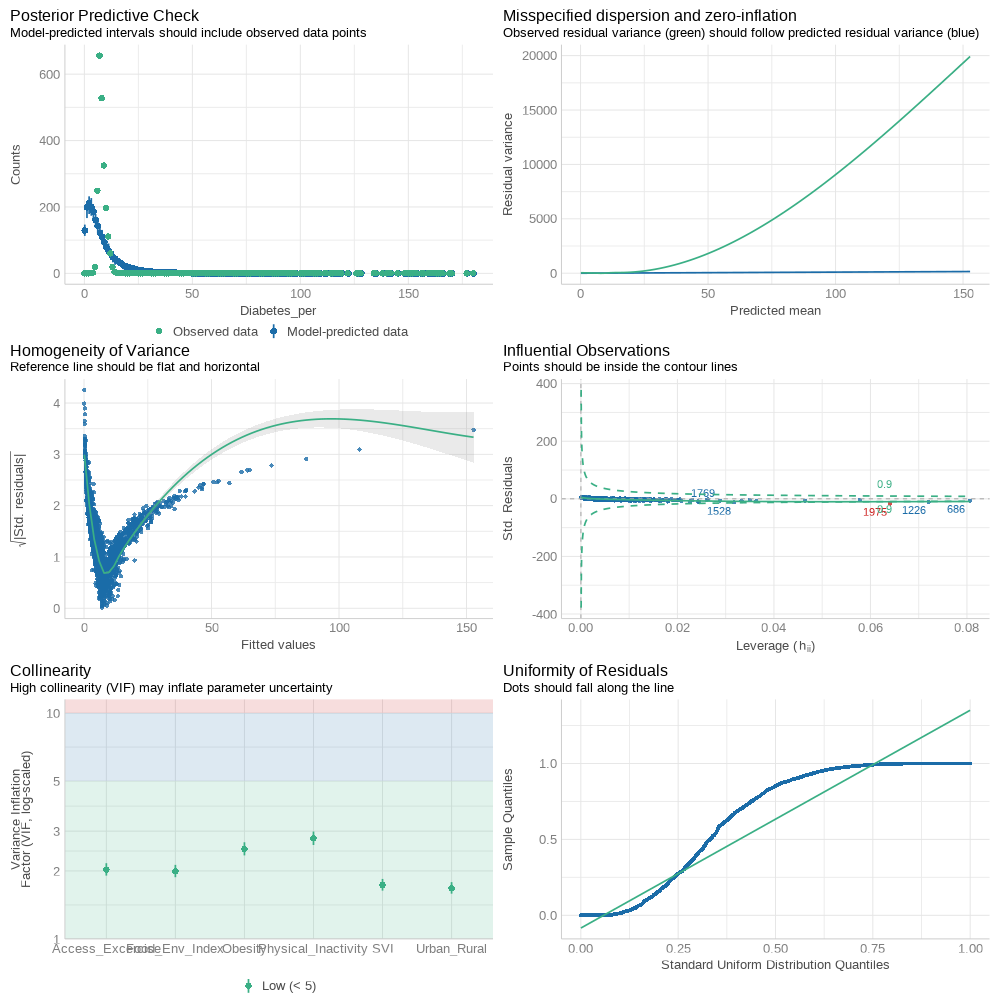

In [ ]:
%%R -h 1000 -w 1000 -u px
performance::check_model(fit.pois)

### Incidence Rate Ratio (IRR)

The Incidence Rate Ratio (IRR) is a measure commonly used in epidemiology and other fields to quantify the association between an exposure or predictor variable and an outcome, particularly when dealing with count data. It is often used in the context of Poisson regression models.

In Poisson regression, the exponentiated coefficients (i.e., exponentiated regression coefficients) are interpreted as Incidence Rate Ratios. Specifically, for a given predictor variable, the IRR represents the multiplicative change in the rate of the outcome for each unit change in the predictor variable.

Mathematically, if $\beta$ is the coefficient estimate of a predictor variable in a Poisson regression model, then the corresponding IRR, denoted as ( \text{IRR} ), is calculated as:

$$ \text{IRR} = e^{\beta} $$

where $e$ is the base of the natural logarithm (approximately equal to 2.718).

Interpretation of the IRR:

-   If $text{IRR} = 1$, it implies that there is no association between the predictor variable and the outcome.

-   If $\text{IRR} > 1$, it indicates that an increase in the predictor variable is associated with an increased incidence rate (or risk) of the outcome.

-   If $\text{IRR} < 1$, it suggests that an increase in the predictor variable is associated with a decreased incidence rate (or risk) of the outcome.

For example, if the IRR associated with a particular exposure is 1.5, it means that the incidence rate of the outcome is 1.5 times higher in the exposed group compared to the unexposed group, all else being equal.

The IRR provides a convenient way to quantify and interpret the strength of association between predictor variables and outcomes in Poisson regression models, particularly when dealing with count data and incidence rates.


In [ ]:
%%R
model_01_IRR = tidy(fit.pois, exponentiate = TRUE,
                       conf.int = TRUE)
model_01_IRR

# A tibble: 7 × 7
  term                estimate std.error statistic   p.value conf.low conf.high
  <chr>                  <dbl>     <dbl>     <dbl>     <dbl>    <dbl>     <dbl>
1 (Intercept)            0.121  0.0883      -23.9  1.07e-126    0.102     0.144
2 Obesity                0.976  0.00255      -9.65 5.07e- 22    0.971     0.981
3 Physical_Inactivity    1.02   0.00289       8.02 1.07e- 15    1.02      1.03 
4 Access_Excercise       0.968  0.000425    -77.4  0            0.967     0.968
5 Food_Env_Index         0.681  0.00939     -40.8  0            0.669     0.694
6 SVI                    0.184  0.0349      -48.4  0            0.172     0.197
7 Urban_RuralUrban       0.345  0.0199      -53.4  0            0.332     0.359


### Marginal Effects and Adjusted Predictions

{ggeffects} supports labelled data and the `plot()`- method automatically sets titles, axis - and legend-labels depending on the value and variable labels of the data

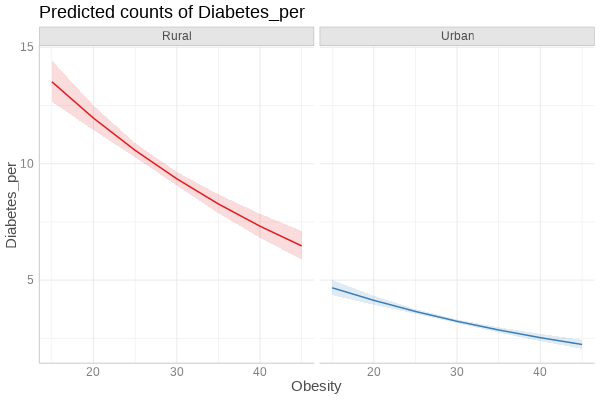

In [ ]:
%%R -h 400 -w 600 -u px
res <- predict_response(fit.pois, terms = c("Obesity", "Urban_Rural"), condition = "log_POP_Total")
plot(res, facets = TRUE)

`effect_plot()` function of {jtools} package plot simple effects in poisson regression models:

Using data train from global environment. This could cause incorrect
results if train has been altered since the model was fit. You can manually
provide the data to the "data =" argument.


Using data train from global environment. This could cause incorrect
results if train has been altered since the model was fit. You can manually
provide the data to the "data =" argument.


Using data train from global environment. This could cause incorrect
results if train has been altered since the model was fit. You can manually
provide the data to the "data =" argument.


Using data train from global environment. This could cause incorrect
results if train has been altered since the model was fit. You can manually
provide the data to the "data =" argument.


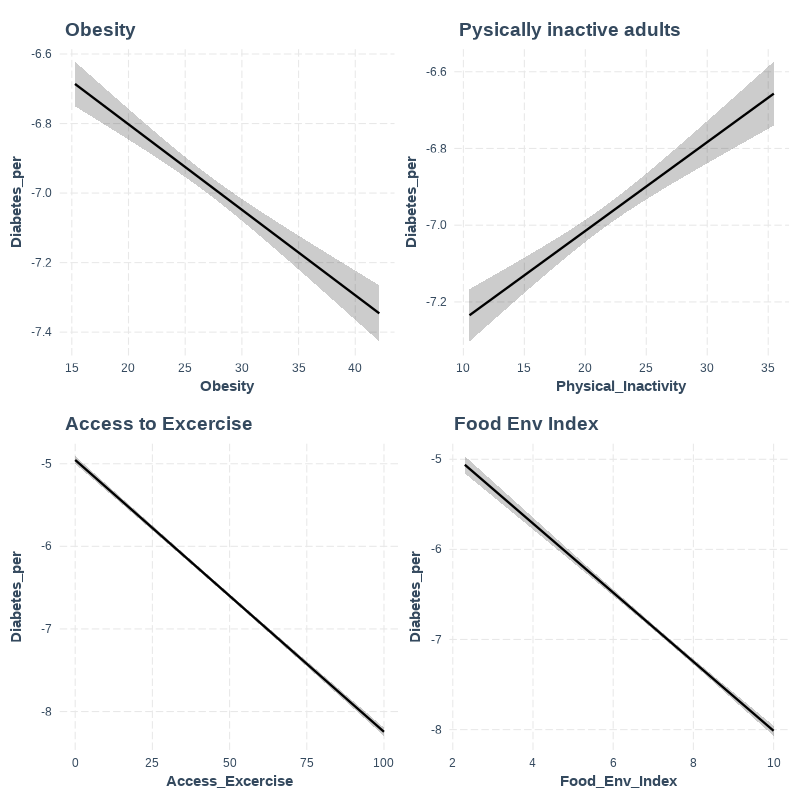

In [ ]:
%%R -h 800 -w 800 -u px
p1<-jtools::effect_plot(fit.pois,
                    main.title = "Obesity",
                    pred = Obesity,
                    interval = T,
                    outcome.scale = "link",
                    partial.residuals = F)
p2<-jtools::effect_plot(fit.pois,
                    main.title = "Pysically inactive adults ",
                    pred = Physical_Inactivity,
                    interval = TRUE,
                    outcome.scale = "link",
                    partial.residuals = F)
p3<-jtools::effect_plot(fit.pois,
                    main.title = "Access to Excercise",
                    pred = Access_Excercise ,
                    interval = TRUE,
                    outcome.scale = "link",
                    partial.residuals = F)
p4<-jtools::effect_plot(fit.pois,
                    main.title = "Food Env Index",
                    pred = Food_Env_Index,
                    interval = TRUE,
                    outcome.scale = "link",
                    partial.residuals = F)
library(patchwork)
(p1+p2)/(p3 +p4)

### Prediction Performance

The `predict()` function will be used to predict the number of diabetes patients the test counties. This will help to validate the accuracy of the these regression model.

In [ ]:
%%R
test$Pred.diabetes<-predict(fit.pois, test, type = "response")
Metrics::rmse(test$Diabetes_per, test$Pred.diabetes)
Metrics::mae(test$Diabetes_per, test$Pred.diabetes)

[1] 5.774231



## Summary and Conclusion

The tutorial explained how to fit a Poisson regression model with offset variables in R, interpret the results, and assess model performance through residual analysis, goodness-of-fit statistics, and predictive accuracy measures like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

Poisson regression with offset variables is an essential extension when modeling rates instead of raw counts. The offset adjusts the model for different levels of exposure across observations, ensuring that the model correctly reflects the rate of events. This technique is particularly useful in applications such as epidemiology, transportation, and insurance, where exposure varies across units.

R provides a straightforward approach to fitting and assessing Poisson regression models with offsets using the `glm()` function. Additionally, various diagnostic tools—such as residual plots, goodness-of-fit tests, and predictive performance measures—can help evaluate how well the model fits the data. When overdispersion is detected, alternatives like Negative Binomial regression should be considered. This tutorial highlighted both the theoretical and practical aspects of applying Poisson regression with offset variables, offering a comprehensive framework for handling count data with varying exposures in R.

## References

1.  [Tutorial: Poisson Regression in R](https://www.dataquest.io/blog/tutorial-poisson-regression-in-r/)

2.  [Chapter 4 Poisson Regression](https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html#sec-overdispPois)

3.  [Chapter 10 Poisson regression](https://bookdown.org/drki_musa/dataanalysis/poisson-regression.html)

4.  [Poisson Regression \| R Data Analysis Examples](https://stats.oarc.ucla.edu/r/dae/poisson-regression/)

5.  [Poisson Regression in R: a complete guided example](https://rpubs.com/Julian_Sampedro/1047952)


Here’s a concise, categorized overview of the R packages with key references:

**Data Manipulation**  
- **`tidyverse`** (Wickham): Meta-package for data science (includes `dplyr`, `ggplot2`, `tidyr`). Streamlines data wrangling and visualization.  
  Reference: [tidyverse.org](https://www.tidyverse.org/), CRAN.  
- **`plyr`** (Wickham): Tools for splitting, applying, and combining data. Predecessor to `dplyr`.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/plyr).  
- **sandwich** (Zeileis): Robust covariance matrix estimators.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/sandwich).

**Statistical Testing & Summarization**  
- **`rstatix`** (Kassambara): Simplifies statistical tests (t-tests, ANOVA) with tidy syntax.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/rstatix).  
- **`gtsummary`** (Sjoberg): Publication-ready summary tables for models and demographics.  
  Reference: [gtsummary](https://www.danieldsjoberg.com/gtsummary/).  
- **`DataExplorer`** (Peters): Automated data exploration and visualization.
  Reference: [CRAN](https://cran.r-project.org/web/packages/DataExplorer).

**Model Diagnostics & Reporting**  
- **`report`** (easystats): Automates interpretation of statistical models.  
  Reference: [easystats.github.io/report](https://easystats.github.io/report/).  
- **`performance`** (easystats): Evaluates model fit (R², RMSE, multicollinearity).  
  Reference: [CRAN](https://cran.r-project.org/web/packages/performance).  
- **`jtools`** (Long): Enhances regression workflows (e.g., `summ()`, `plot_coefs()`).  
  Reference: [CRAN](https://cran.r-project.org/web/packages/jtools).  
- **`sjPlot`** (Lüdecke): Visualizes model outputs (e.g., `plot_model()`).  
  Reference: [CRAN](https://cran.r-project.org/web/packages/sjPlot).  

**Marginal Effects & Predictions**  
- **`margins`** (Leeper): Computes marginal effects for regression models.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/margins).  
- **`marginaleffects`** (Arel-Bundock): Modern tool for predictions and slopes.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/marginaleffects).  
- **`ggeffects`** (Lüdecke): Tidy predictions for plotting marginal effects.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/ggeffects).  

**Visualization & Tables**  
- **`gt`** (Iannone): Creates polished, customizable tables.  
  Reference: [gt.rstudio.com](https://gt.rstudio.com/).  
- **`patchwork`** (Pedersen): Combines `ggplot2` plots into layouts.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/patchwork).  
- **`ggpmisc`** (Aphalo): Adds stats and annotations to `ggplot2`.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/ggpmisc).  
- **`RColorBrewer`** (Neuwirth): Color palettes for visualization.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/RColorBrewer).  
- **`epiDisplay`** (Tomas): Data presentation and epidemiological functions.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/epiDisplay).

**Model Evaluation**  
- **`Metrics`** (Hamner): Implements metrics like RMSE, AUC.  
  Reference: [CRAN](https://cran.r-project.org/web/packages/Metrics).  
- **`metrica`** (Garcia): Additional evaluation metrics (e.g., precision, recall).  
  Reference: [CRAN](https://cran.r-project.org/web/packages/metrica).  

**Advanced Statistical Modeling**  
- **`MASS`** (Venables & Ripley): Robust regression, LDA, GLMs (e.g., `glm.nb`).  
  Reference: [CRAN](https://cran.r-project.org/web/packages/MASS).  
  